# LOAD DATA

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, Conv2D, MaxPooling2D, BatchNormalization, Activation, Add, SeparableConv2D, MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from itertools import product
import random
import optuna
from optuna.integration import TFKerasPruningCallback

In [2]:
# Verify GPU availability
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

base_dir = 'C:\\Users\\Θάνος\\Desktop\\Thesis Thanasis\\data_aug_3'
subfolders = ['clear', 'clouds']
categories = ['Healthy_augmented', 'Damaged_augmented']
IMG_HEIGHT = 128
IMG_WIDTH = 123
BATCH_SIZE = 32

def load_data(base_dir, subfolders, categories, img_height, img_width):
    data = []
    labels = []
    image_paths = []
    for category in categories:
        class_num = categories.index(category)
        for subfolder in subfolders:
            folder_path = os.path.join(base_dir, subfolder, category)
            images = sorted(os.listdir(folder_path))
            for img_name in images:
                if img_name.endswith('.png'):
                    img_path = os.path.join(folder_path, img_name)
                    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_height, img_width))
                    img_array = tf.keras.preprocessing.image.img_to_array(img)
                    data.append(img_array)
                    labels.append(class_num)
                    image_paths.append((subfolder, category, img_name))
    return np.array(data), np.array(labels), image_paths

data, labels, image_paths = load_data(base_dir, subfolders, categories, IMG_HEIGHT, IMG_WIDTH)
data = data / 255.0

# Split data ensuring twins are in the same split
def split_data(image_paths):
    unique_image_ids = list(set([img_name for subfolder, category, img_name in image_paths]))
    train_ids, test_ids = train_test_split(unique_image_ids, test_size=0.2, random_state=42)
    train_ids, val_ids = train_test_split(train_ids, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2
    return train_ids, val_ids, test_ids

def get_split_indices(image_paths, split_ids):
    split_indices = [i for i, (subfolder, category, img_name) in enumerate(image_paths) if img_name in split_ids]
    return split_indices

train_ids, val_ids, test_ids = split_data(image_paths)
train_indices = get_split_indices(image_paths, train_ids)
val_indices = get_split_indices(image_paths, val_ids)
test_indices = get_split_indices(image_paths, test_ids)

X_train, y_train = data[train_indices], labels[train_indices]
X_val, y_val = data[val_indices], labels[val_indices]
X_test, y_test = data[test_indices], labels[test_indices]

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation labels shape: {y_val.shape}")
print(f"Test labels shape: {y_test.shape}")

TensorFlow version: 2.10.0
Num GPUs Available:  1
Training data shape: (7248, 64, 64, 3)
Validation data shape: (2416, 64, 64, 3)
Test data shape: (2416, 64, 64, 3)
Training labels shape: (7248, 2)
Validation labels shape: (2416, 2)
Test labels shape: (2416, 2)


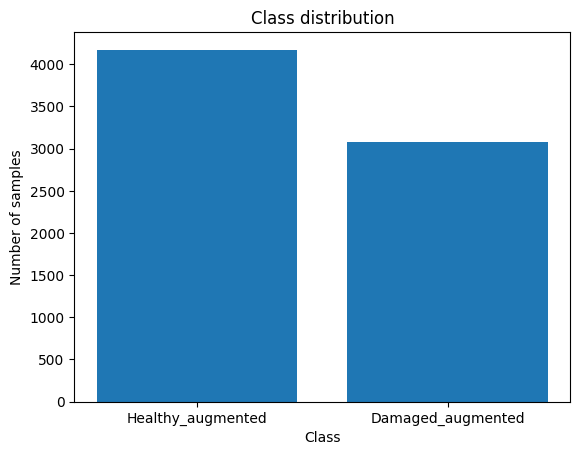

In [3]:
# Check class distribution
def plot_class_distribution(labels, categories):
    class_counts = np.sum(labels, axis=0)
    plt.bar(categories, class_counts)
    plt.xlabel('Class')
    plt.ylabel('Number of samples')
    plt.title('Class distribution')
    plt.show()

plot_class_distribution(y_train, categories)

# VISUALIZE DATA

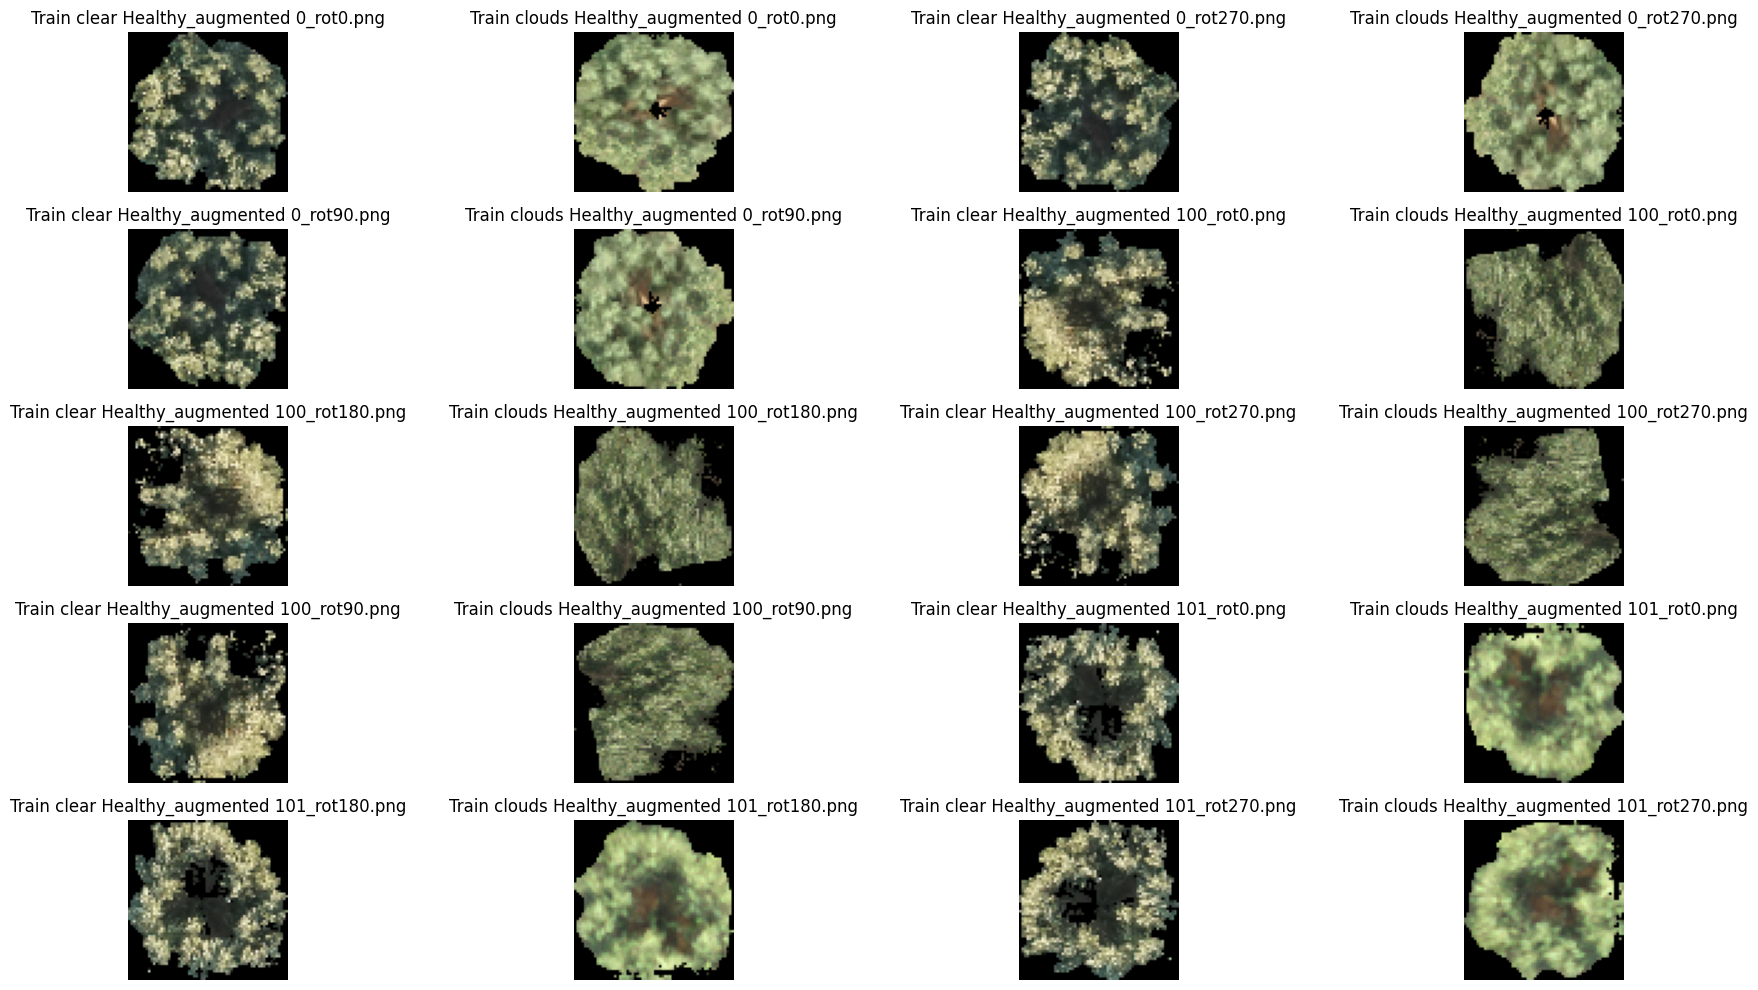

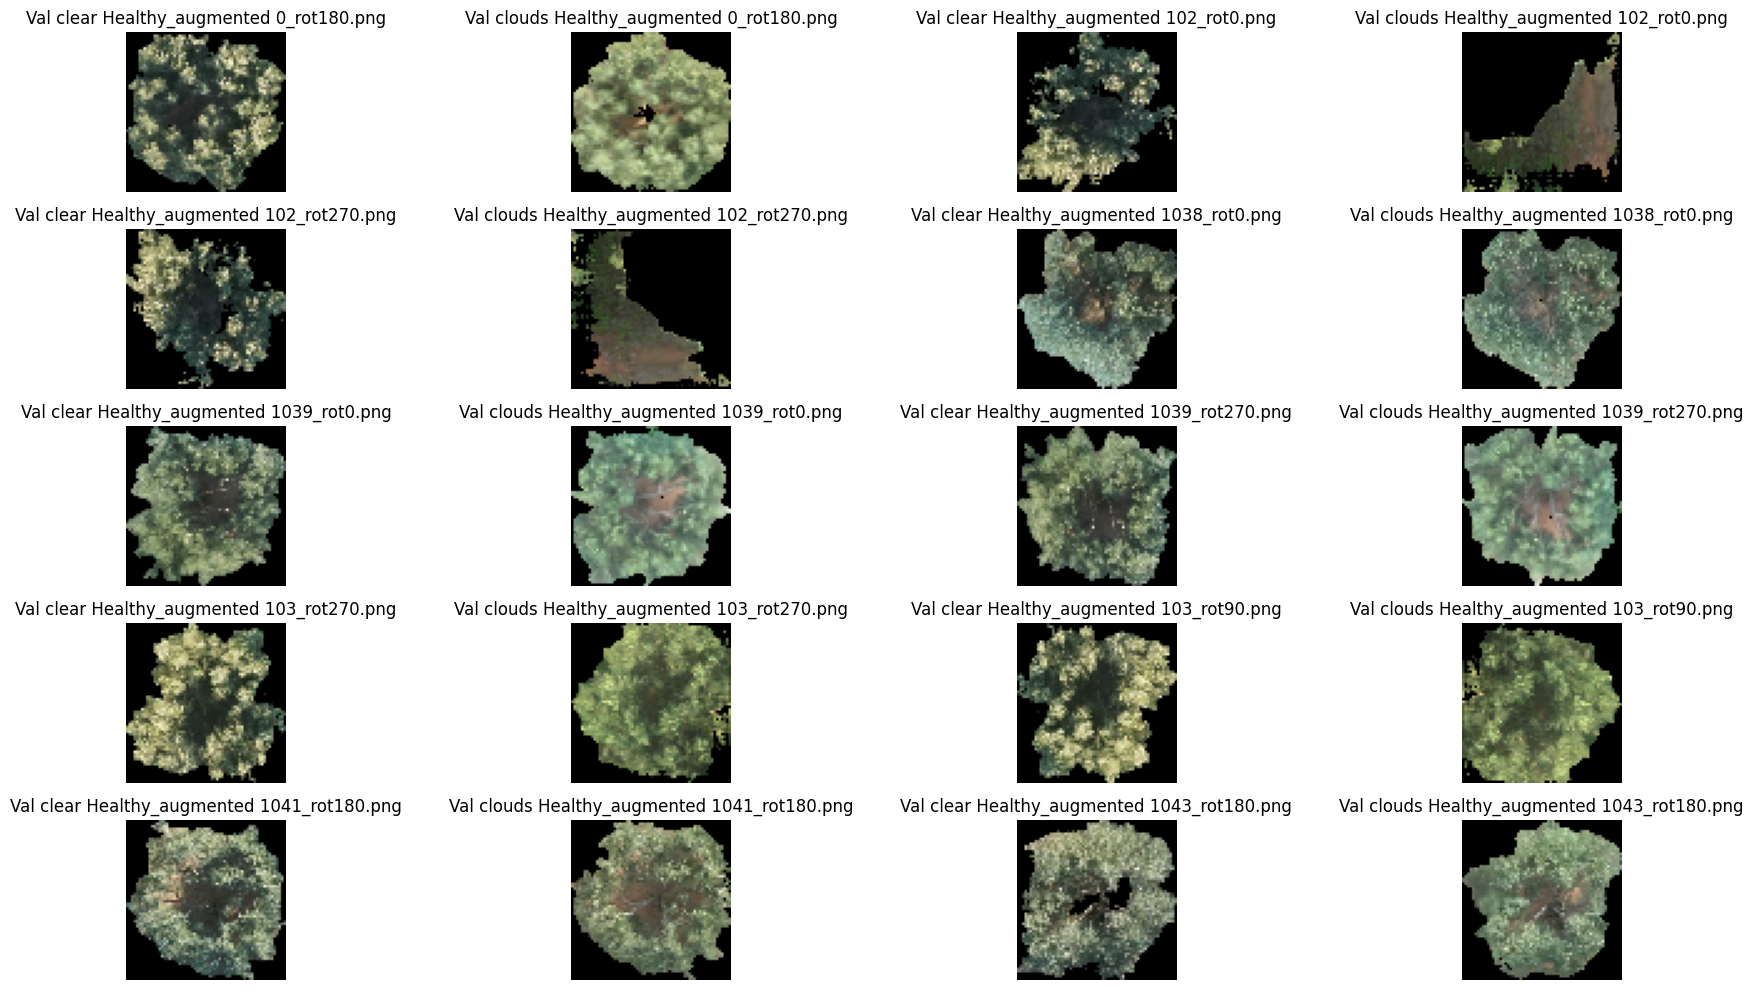

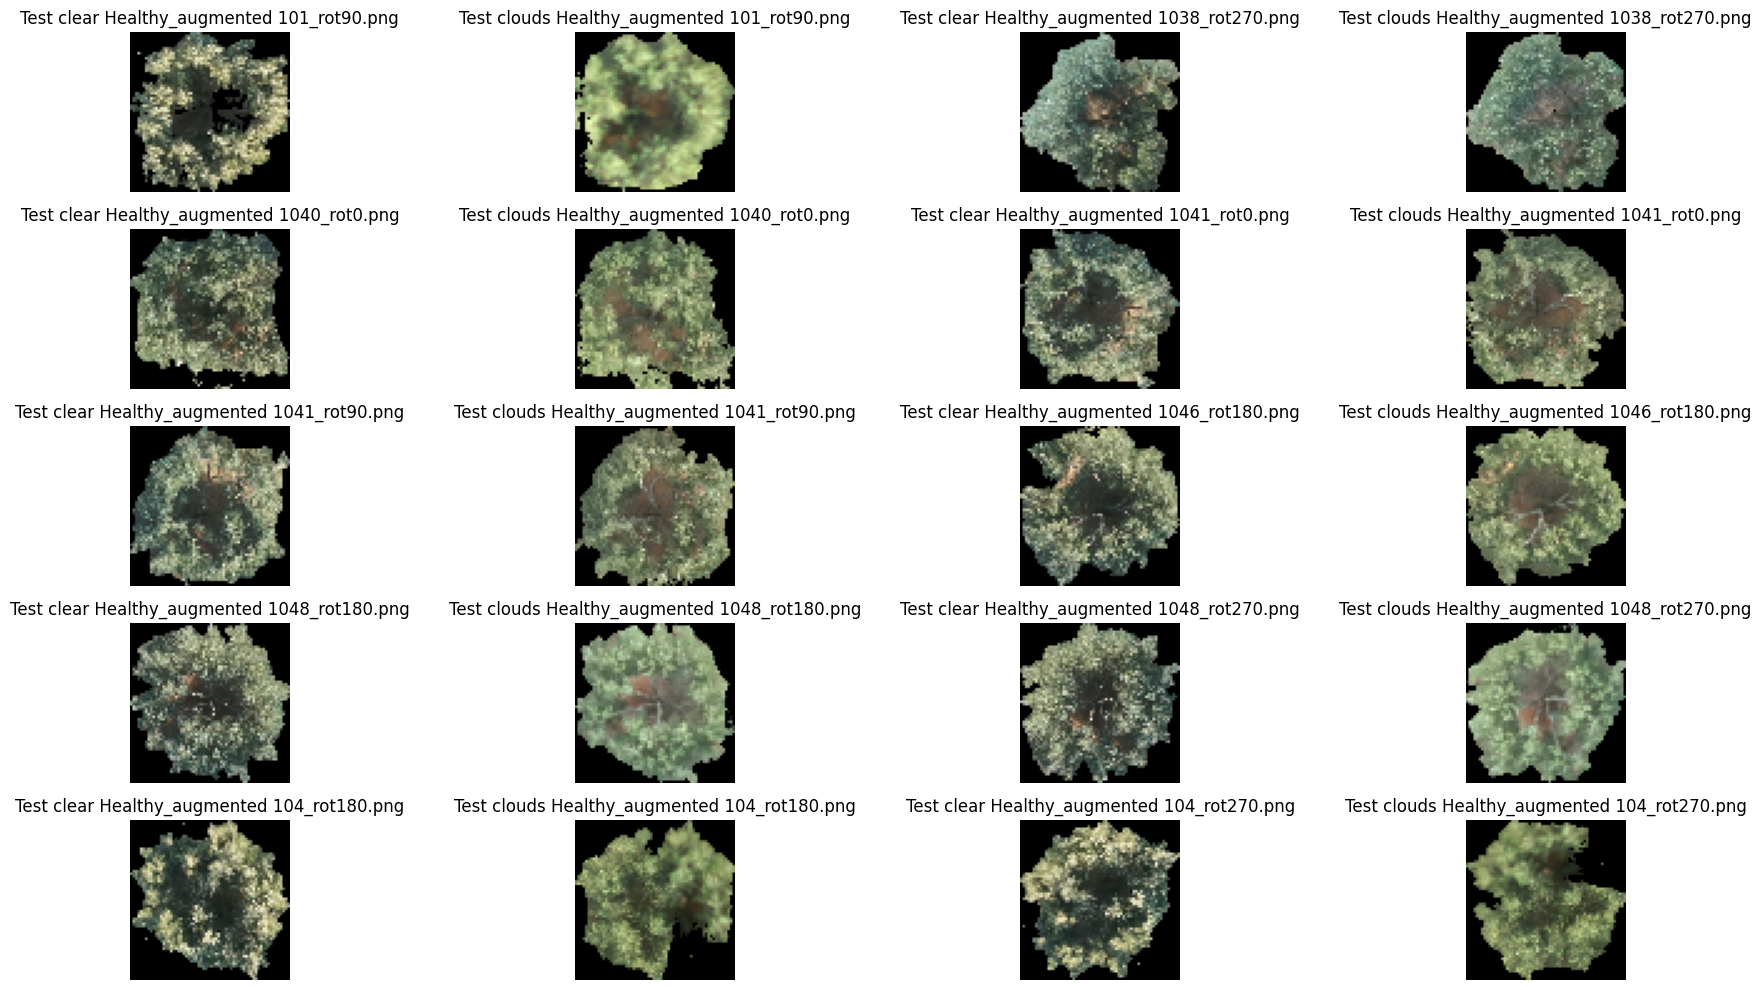

In [4]:
# Visualize images to verify correct loading
def visualize_images(image_paths, indices, title):
    plt.figure(figsize=(20, 10))
    for i, idx in enumerate(indices[:10]):
        subfolder, category, img_name = image_paths[idx]
        img_path = os.path.join(base_dir, subfolder, category, img_name)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        plt.subplot(5, 4, 2 * i + 1)
        plt.imshow(img)
        plt.title(f"{title} {subfolder} {category} {img_name}")
        plt.axis('off')

        # Find the twin image
        twin_subfolder = 'clear' if subfolder == 'clouds' else 'clouds'
        twin_img_path = os.path.join(base_dir, twin_subfolder, category, img_name)
        twin_img = tf.keras.preprocessing.image.load_img(twin_img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        plt.subplot(5, 4, 2 * i + 2)
        plt.imshow(twin_img)
        plt.title(f"{title} {twin_subfolder} {category} {img_name}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize training images
visualize_images(image_paths, train_indices, 'Train')

# Visualize validation images
visualize_images(image_paths, val_indices, 'Val')

# Visualize test images
visualize_images(image_paths, test_indices, 'Test')

# MODEL ARCHITECTURE AND TRAIN MODEL

In [3]:
# Define data augmentation with seed
def create_datagen(seed=None):
    return ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    ), seed

datagen, seed = create_datagen(seed=42)  # Set the seed for reproducibility
datagen.fit(X_train)
train_generator = datagen.flow(X_train, y_train, batch_size=BATCH_SIZE, seed=seed)  # Use the seed here too

def residual_block(x, filters, kernel_size):
    shortcut = x
    x = Conv2D(filters, (kernel_size, kernel_size), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)
    x = Conv2D(filters, (kernel_size, kernel_size), padding='same')(x)
    x = BatchNormalization()(x)
    
    if shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, (1, 1), padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)
        
    x = Add()([x, shortcut])
    x = Activation('tanh')(x)
    return x
    
# Modified model architecture
def build_complex_model(input_shape, num_residual_blocks, dropout_rate, filters, kernel_size, num_dense_layers, activation_function, learning_rate):
    combined_input = Input(shape=(input_shape[1], input_shape[2], input_shape[3]), name='combined_input')
    
    x = Conv2D(filters, (kernel_size, kernel_size), activation=activation_function, padding='same')(combined_input)
    x = MaxPooling2D((2, 2))(x)
    for _ in range(num_residual_blocks):
        x = residual_block(x, filters, kernel_size)
        if x.shape[1] >= 2 and x.shape[2] >= 2:
            x = MaxPooling2D((2, 2))(x)
    x = GlobalAveragePooling2D()(x)
    
    for _ in range(num_dense_layers):
        x = Dense(2048, activation=activation_function)(x)
        x = Dropout(dropout_rate)(x)
        x = BatchNormalization()(x)
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs=combined_input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

input_shape = X_train.shape

# Hyperparameter tuning parameters (only architecture and training-related)
num_residual_blocks_options = [2]
dropout_rate_options = [0.3]
filters_options = [64]
kernel_size_options = [3, 5]
num_dense_layers_options = [2, 3]
activation_function_options = ['tanh']
learning_rate_options = [1e-2, 1e-3, 1e-4]

# Create grid search parameter combinations
parameter_combinations = list(product(num_residual_blocks_options, dropout_rate_options, filters_options, kernel_size_options, num_dense_layers_options, activation_function_options, learning_rate_options))

# Compute class weights using the training set
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(np.argmax(y_train, axis=1)), y=np.argmax(y_train, axis=1))
class_weights = dict(enumerate(class_weights))

print(f"Class weights: {class_weights}")

# Callbacks for training
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Perform exhaustive search for hyperparameter tuning
best_val_accuracy = 0
best_params = None
best_model_save_path = 'best_model_tuning.h5'

for idx, (num_residual_blocks, dropout_rate, filters, kernel_size, num_dense_layers, activation_function, learning_rate) in enumerate(parameter_combinations):
    print(f"\nCombination {idx + 1}/{len(parameter_combinations)}: num_residual_blocks={num_residual_blocks}, dropout_rate={dropout_rate}, filters={filters}, kernel_size={kernel_size}, num_dense_layers={num_dense_layers}, activation_function={activation_function}, learning_rate={learning_rate}")
    
    model = build_complex_model(input_shape, num_residual_blocks, dropout_rate, filters, kernel_size, num_dense_layers, activation_function, learning_rate)
    
    with tf.device('/GPU:0'):
        history = model.fit(
            train_generator,
            steps_per_epoch=len(X_train) // BATCH_SIZE,
            epochs=50,
            validation_data=(X_val, y_val),
            callbacks=[reduce_lr, early_stopping],
            class_weight=class_weights,
            verbose=1
        )
    
    val_accuracy = history.history['val_accuracy'][-1]
    print(f"Validation accuracy: {val_accuracy}")
    
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_params = (num_residual_blocks, dropout_rate, filters, kernel_size, num_dense_layers, activation_function, learning_rate)
        model.save(best_model_save_path)
        print(f"Model with validation accuracy {val_accuracy} saved to {best_model_save_path}")

print(f"\nBest parameters found: num_residual_blocks={best_params[0]}, dropout_rate={best_params[1]}, filters={best_params[2]}, kernel_size={best_params[3]}, num_dense_layers={best_params[4]}, activation_function={best_params[5]}, learning_rate={best_params[6]}")
print(f"Best validation accuracy: {best_val_accuracy}")

# Load the best model from the hyperparameter tuning phase
best_model = tf.keras.models.load_model(best_model_save_path)

# Retrain the best model on the train dataset only
datagen, seed = create_datagen(seed=42)
datagen.fit(X_train)
train_generator = datagen.flow(X_train, y_train, batch_size=BATCH_SIZE, seed=seed)

# Make predictions on the test set
with tf.device('/GPU:0'):
    history = best_model.fit(
        train_generator,
        steps_per_epoch=len(X_train) // BATCH_SIZE,
        epochs=50,
        validation_data=(X_val, y_val),
        callbacks=[reduce_lr, early_stopping],
        class_weight=class_weights,
        verbose=1
    )

# Save the retrained model
final_model_save_path = 'C:\\Users\\Θάνος\\Desktop\\Thesis Thanasis\\succ_model_1\\best_model_retrained.h5'
best_model.save(final_model_save_path)
print(f"Final model saved to {final_model_save_path}")

# Make predictions on the test set
with tf.device('/GPU:0'):
    test_predictions = best_model.predict(X_test)


# Convert one-hot encoded predictions and true labels to label indices
y_test_true = np.argmax(y_test, axis=1)
y_test_pred = np.argmax(test_predictions, axis=1)

# Generate the confusion matrix for the test set
test_conf_matrix = confusion_matrix(y_test_true, y_test_pred)

print("Confusion Matrix (Test):")
print(test_conf_matrix)

# Generate the classification report for the test set
test_class_report = classification_report(y_test_true, y_test_pred, target_names=categories)

print("Classification Report (Test):")
print(test_class_report)

Class weights: {0: 0.8511038046031001, 1: 1.2120401337792641}

Combination 1/12: num_residual_blocks=2, dropout_rate=0.3, filters=64, kernel_size=3, num_dense_layers=2, activation_function=tanh, learning_rate=0.01
Epoch 1/50
906/906 [==============================] - 32s 27ms/step - loss: 2.1298 - accuracy: 0.4981 - val_loss: 1.5711 - val_accuracy: 0.5836 - lr: 0.0100
Epoch 2/50
906/906 [==============================] - 23s 26ms/step - loss: 1.1988 - accuracy: 0.5110 - val_loss: 0.7874 - val_accuracy: 0.4350 - lr: 0.0100
Epoch 3/50
906/906 [==============================] - 24s 26ms/step - loss: 0.8420 - accuracy: 0.4932 - val_loss: 0.7185 - val_accuracy: 0.4127 - lr: 0.0100
Epoch 4/50
906/906 [==============================] - 24s 26ms/step - loss: 0.7555 - accuracy: 0.5012 - val_loss: 0.7208 - val_accuracy: 0.4131 - lr: 0.0100
Epoch 5/50
906/906 [==============================] - 24s 26ms/step - loss: 0.7240 - accuracy: 0.5103 - val_loss: 0.7790 - val_accuracy: 0.4139 - lr: 0.0100
E

OPTUNA 

In [3]:
# Define data augmentation with seed
def create_datagen(seed=None):
    return ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        fill_mode='nearest'
    ), seed

datagen, seed = create_datagen(seed=42)  # Set the seed for reproducibility
datagen.fit(X_train)
train_generator = datagen.flow(X_train, y_train, batch_size=BATCH_SIZE, seed=seed)  # Use the seed here too
val_generator = datagen.flow(X_val, y_val, batch_size=BATCH_SIZE, seed=seed)

# Compute class weights using the training set
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(np.argmax(y_train, axis=1)), y=np.argmax(y_train, axis=1))
class_weights = dict(enumerate(class_weights))

print(f"Class weights: {class_weights}")

# Define custom model with more complexity
def residual_block(x, filters, kernel_size):
    shortcut = x
    x = SeparableConv2D(filters, (kernel_size, kernel_size), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(filters, (kernel_size, kernel_size), padding='same')(x)
    x = BatchNormalization()(x)
    
    if shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, (1, 1), padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)
        
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def build_model(trial):
    num_residual_blocks = trial.suggest_int('num_residual_blocks', 2, 5)
    filters = trial.suggest_int('filters', 32, 128)
    kernel_size = trial.suggest_int('kernel_size', 3, 5)
    dense_units = trial.suggest_int('dense_units', 512, 2048)
    dropout_rate = trial.suggest_float('dropout_rate', 0.3, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    
    inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    
    x = Conv2D(filters, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    for _ in range(num_residual_blocks):
        x = residual_block(x, filters, kernel_size)
        if x.shape[1] >= 2 and x.shape[2] >= 2:
            x = MaxPooling2D((2, 2))(x)
    x = GlobalAveragePooling2D()(x)
    
    x = Dense(dense_units, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(2, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Objective function for Optuna
def objective(trial):
    model = build_model(trial)
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, verbose=1)
    
    history = model.fit(
        train_generator,
        steps_per_epoch=len(X_train) // BATCH_SIZE,
        epochs=50,
        validation_data=val_generator,
        class_weight=class_weights,
        callbacks=[early_stopping, reduce_lr, TFKerasPruningCallback(trial, 'val_loss')],
        verbose=1
    )
    
    val_accuracy = np.max(history.history['val_accuracy'])
    return val_accuracy

# Run the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print the best parameters
print("Best parameters found: ", study.best_params)
print("Best score: ", study.best_value)

# Train the best model on the full training data
best_model_params = study.best_params
best_model = build_model(optuna.trial.FixedTrial(best_model_params))

with tf.device('/GPU:0'):
    history = best_model.fit(
        train_generator,
        steps_per_epoch=len(X_train) // BATCH_SIZE,
        epochs=150,
        validation_data=val_generator,
        class_weight=class_weights,
        callbacks=[EarlyStopping(monitor='loss', patience=10, restore_best_weights=True), ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=1e-7, verbose=1)],
        verbose=1
    )

# Save the fine-tuned model
fine_tuned_model_path = 'beest_custom_model_optuna.h5'
best_model.save(fine_tuned_model_path)
print(f"Best custom model fine-tuned model saved to {fine_tuned_model_path}")

# Evaluate the model on the test set
test_predictions = best_model.predict(X_test)

# Convert one-hot encoded predictions and true labels to label indices
y_test_true = np.argmax(y_test, axis=1)
y_test_pred = np.argmax(test_predictions, axis=1)

# Generate the confusion matrix for the test set
test_conf_matrix = confusion_matrix(y_test_true, y_test_pred)

print(f"Confusion Matrix (Test) for Best Custom Model:")
print(test_conf_matrix)

# Generate the classification report for the test set
test_class_report = classification_report(y_test_true, y_test_pred, target_names=categories)

print(f"Classification Report (Test) for Best Custom Model:")
print(test_class_report)

[I 2024-08-02 14:41:26,558] A new study created in memory with name: no-name-38dd16a6-2669-4177-93d5-482f20c5b1b1


Class weights: {0: 0.8451492537313433, 1: 1.2243243243243243}


C:\Users\Θάνος\AppData\Local\Temp\ipykernel_8056\1785677575.py:47: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Epoch 1/50
906/906 [==============================] - 29s 25ms/step - loss: 0.7333 - accuracy: 0.5148 - val_loss: 0.7347 - val_accuracy: 0.4371 - lr: 3.2686e-04
Epoch 2/50
906/906 [==============================] - 22s 25ms/step - loss: 0.6994 - accuracy: 0.5295 - val_loss: 0.6779 - val_accuracy: 0.5654 - lr: 3.2686e-04
Epoch 3/50
906/906 [==============================] - 23s 25ms/step - loss: 0.6910 - accuracy: 0.5519 - val_loss: 0.6924 - val_accuracy: 0.5600 - lr: 3.2686e-04
Epoch 4/50
906/906 [==============================] - 22s 25ms/step - loss: 0.6832 - accuracy: 0.5642 - val_loss: 0.8030 - val_accuracy: 0.4404 - lr: 3.2686e-04
Epoch 5/50
904/906 [============================>.] - ETA: 0s - loss: 0.6811 - accuracy: 0.5694
Epoch 5: ReduceLROnPlateau reducing learning rate to 6.53719122055918e-05.
906/906 [==============================] - 22s 25ms/step - loss: 0.6813 - accuracy: 0.5693 - val_loss: 0.7117 - val_accuracy: 0.4681 - lr: 3.2686e-04
Epoch 6/50
906/906 [===============

[I 2024-08-02 14:49:06,522] Trial 0 finished with value: 0.6043046116828918 and parameters: {'num_residual_blocks': 3, 'filters': 53, 'kernel_size': 5, 'dense_units': 1373, 'dropout_rate': 0.4290158383473887, 'learning_rate': 0.00032685955110068395}. Best is trial 0 with value: 0.6043046116828918.


Epoch 1/50
906/906 [==============================] - 20s 21ms/step - loss: 0.7071 - accuracy: 0.4921 - val_loss: 0.6936 - val_accuracy: 0.4371 - lr: 0.0028
Epoch 2/50
906/906 [==============================] - 19s 20ms/step - loss: 0.6939 - accuracy: 0.4912 - val_loss: 0.6952 - val_accuracy: 0.4371 - lr: 0.0028
Epoch 3/50
906/906 [==============================] - 19s 21ms/step - loss: 0.6935 - accuracy: 0.4797 - val_loss: 0.6970 - val_accuracy: 0.4371 - lr: 0.0028
Epoch 4/50
905/906 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5077
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005516466218978167.
906/906 [==============================] - 19s 21ms/step - loss: 0.6935 - accuracy: 0.5079 - val_loss: 0.6958 - val_accuracy: 0.4371 - lr: 0.0028
Epoch 5/50
906/906 [==============================] - 19s 21ms/step - loss: 0.6933 - accuracy: 0.4379 - val_loss: 0.6941 - val_accuracy: 0.4371 - lr: 5.5165e-04
Epoch 6/50
906/906 [==============================

[I 2024-08-02 14:52:54,507] Trial 1 finished with value: 0.5629138946533203 and parameters: {'num_residual_blocks': 2, 'filters': 55, 'kernel_size': 3, 'dense_units': 1941, 'dropout_rate': 0.4910049038797966, 'learning_rate': 0.0027582331775459173}. Best is trial 0 with value: 0.6043046116828918.


Epoch 1/50
906/906 [==============================] - 35s 36ms/step - loss: 0.7605 - accuracy: 0.4873 - val_loss: 22.0998 - val_accuracy: 0.5629 - lr: 0.0020
Epoch 2/50
906/906 [==============================] - 32s 36ms/step - loss: 0.6971 - accuracy: 0.5159 - val_loss: 0.6895 - val_accuracy: 0.5629 - lr: 0.0020
Epoch 3/50
906/906 [==============================] - 32s 36ms/step - loss: 0.6953 - accuracy: 0.4739 - val_loss: 0.6930 - val_accuracy: 0.5062 - lr: 0.0020
Epoch 4/50
906/906 [==============================] - 32s 35ms/step - loss: 0.6938 - accuracy: 0.4695 - val_loss: 0.6936 - val_accuracy: 0.4354 - lr: 0.0020
Epoch 5/50
906/906 [==============================] - ETA: 0s - loss: 0.6952 - accuracy: 0.5319
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00039152293466031556.
906/906 [==============================] - 32s 36ms/step - loss: 0.6952 - accuracy: 0.5319 - val_loss: 0.6913 - val_accuracy: 0.5629 - lr: 0.0020
Epoch 6/50
906/906 [==============================] 

[I 2024-08-02 14:56:43,144] Trial 2 finished with value: 0.5629138946533203 and parameters: {'num_residual_blocks': 4, 'filters': 85, 'kernel_size': 5, 'dense_units': 1817, 'dropout_rate': 0.4063677700255003, 'learning_rate': 0.0019576145858325924}. Best is trial 0 with value: 0.6043046116828918.


Epoch 1/50
906/906 [==============================] - 30s 31ms/step - loss: 0.7506 - accuracy: 0.4890 - val_loss: 0.6988 - val_accuracy: 0.4371 - lr: 0.0094
Epoch 2/50
906/906 [==============================] - 28s 31ms/step - loss: 0.6942 - accuracy: 0.5025 - val_loss: 0.6964 - val_accuracy: 0.4371 - lr: 0.0094
Epoch 3/50
906/906 [==============================] - 28s 31ms/step - loss: 0.6939 - accuracy: 0.4903 - val_loss: 0.6925 - val_accuracy: 0.5629 - lr: 0.0094
Epoch 4/50
906/906 [==============================] - 28s 31ms/step - loss: 0.6942 - accuracy: 0.4906 - val_loss: 0.6927 - val_accuracy: 0.5629 - lr: 0.0094
Epoch 5/50
906/906 [==============================] - 28s 31ms/step - loss: 0.6937 - accuracy: 0.5025 - val_loss: 0.7006 - val_accuracy: 0.4371 - lr: 0.0094
Epoch 6/50
905/906 [============================>.] - ETA: 0s - loss: 0.6948 - accuracy: 0.5091
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0018832221627235414.
906/906 [==============================] - 

[I 2024-08-02 15:04:42,661] Trial 3 finished with value: 0.5629138946533203 and parameters: {'num_residual_blocks': 2, 'filters': 99, 'kernel_size': 5, 'dense_units': 1852, 'dropout_rate': 0.4570979416353777, 'learning_rate': 0.009416111113396393}. Best is trial 0 with value: 0.6043046116828918.


Epoch 1/50
906/906 [==============================] - 20s 21ms/step - loss: 0.7088 - accuracy: 0.5025 - val_loss: 0.6990 - val_accuracy: 0.4371 - lr: 0.0013
Epoch 2/50
906/906 [==============================] - 20s 22ms/step - loss: 0.6938 - accuracy: 0.4677 - val_loss: 0.6916 - val_accuracy: 0.5629 - lr: 0.0013
Epoch 3/50
906/906 [==============================] - 20s 22ms/step - loss: 0.6935 - accuracy: 0.5287 - val_loss: 0.6950 - val_accuracy: 0.4371 - lr: 0.0013
Epoch 4/50
906/906 [==============================] - 20s 22ms/step - loss: 0.6933 - accuracy: 0.4963 - val_loss: 0.6921 - val_accuracy: 0.5629 - lr: 0.0013
Epoch 5/50
904/906 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5116
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00025293438229709867.
906/906 [==============================] - 20s 22ms/step - loss: 0.6935 - accuracy: 0.5117 - val_loss: 0.6936 - val_accuracy: 0.4371 - lr: 0.0013
Epoch 6/50
906/906 [==============================] -

[I 2024-08-02 15:07:01,349] Trial 4 finished with value: 0.5629138946533203 and parameters: {'num_residual_blocks': 2, 'filters': 50, 'kernel_size': 5, 'dense_units': 1016, 'dropout_rate': 0.31324895051820884, 'learning_rate': 0.0012646719108578394}. Best is trial 0 with value: 0.6043046116828918.


Epoch 1/50
905/906 [============================>.] - ETA: 0s - loss: 0.7289 - accuracy: 0.5200

[I 2024-08-02 15:07:25,286] Trial 5 pruned. Trial was pruned at epoch 0.


Epoch 1/50
903/906 [============================>.] - ETA: 0s - loss: 0.7120 - accuracy: 0.4911

[I 2024-08-02 15:07:44,694] Trial 6 pruned. Trial was pruned at epoch 0.


Epoch 1/50
906/906 [==============================] - 26s 27ms/step - loss: 0.7109 - accuracy: 0.5196 - val_loss: 0.9596 - val_accuracy: 0.5629 - lr: 0.0030
Epoch 2/50
906/906 [==============================] - 24s 26ms/step - loss: 0.6956 - accuracy: 0.5025 - val_loss: 0.7274 - val_accuracy: 0.4371 - lr: 0.0030
Epoch 3/50
906/906 [==============================] - 24s 26ms/step - loss: 0.6944 - accuracy: 0.4961 - val_loss: 0.6889 - val_accuracy: 0.5629 - lr: 0.0030
Epoch 4/50
906/906 [==============================] - 24s 26ms/step - loss: 0.6935 - accuracy: 0.5099 - val_loss: 0.6969 - val_accuracy: 0.4371 - lr: 0.0030
Epoch 5/50
906/906 [==============================] - 24s 26ms/step - loss: 0.6935 - accuracy: 0.5068 - val_loss: 0.6908 - val_accuracy: 0.5629 - lr: 0.0030
Epoch 6/50
906/906 [==============================] - 24s 26ms/step - loss: 0.6929 - accuracy: 0.5225 - val_loss: 0.6874 - val_accuracy: 0.5629 - lr: 0.0030
Epoch 7/50
906/906 [==============================] - 24s 

[I 2024-08-02 15:12:10,205] Trial 7 finished with value: 0.5629138946533203 and parameters: {'num_residual_blocks': 2, 'filters': 73, 'kernel_size': 5, 'dense_units': 814, 'dropout_rate': 0.43937786157128406, 'learning_rate': 0.0030400746014108706}. Best is trial 0 with value: 0.6043046116828918.


Epoch 1/50
904/906 [============================>.] - ETA: 0s - loss: 0.7008 - accuracy: 0.4878

[I 2024-08-02 15:12:34,955] Trial 8 pruned. Trial was pruned at epoch 0.


Epoch 1/50
906/906 [==============================] - ETA: 0s - loss: 0.7851 - accuracy: 0.5159

[I 2024-08-02 15:13:01,211] Trial 9 pruned. Trial was pruned at epoch 0.


Epoch 1/50
906/906 [==============================] - 42s 44ms/step - loss: 0.9250 - accuracy: 0.4990 - val_loss: 0.7212 - val_accuracy: 0.5629 - lr: 1.0145e-04
Epoch 2/50
906/906 [==============================] - 40s 44ms/step - loss: 0.7295 - accuracy: 0.5237 - val_loss: 0.6852 - val_accuracy: 0.5526 - lr: 1.0145e-04
Epoch 3/50
906/906 [==============================] - 40s 45ms/step - loss: 0.6980 - accuracy: 0.5421 - val_loss: 0.7845 - val_accuracy: 0.4512 - lr: 1.0145e-04
Epoch 4/50
906/906 [==============================] - 40s 44ms/step - loss: 0.6917 - accuracy: 0.5433 - val_loss: 0.7307 - val_accuracy: 0.5178 - lr: 1.0145e-04
Epoch 5/50
905/906 [============================>.] - ETA: 0s - loss: 0.6844 - accuracy: 0.5576
Epoch 5: ReduceLROnPlateau reducing learning rate to 2.029080205829814e-05.
906/906 [==============================] - 39s 43ms/step - loss: 0.6845 - accuracy: 0.5577 - val_loss: 0.7326 - val_accuracy: 0.4578 - lr: 1.0145e-04
Epoch 6/50
906/906 [==============

[I 2024-08-02 15:22:25,526] Trial 10 finished with value: 0.6105132699012756 and parameters: {'num_residual_blocks': 5, 'filters': 127, 'kernel_size': 4, 'dense_units': 1291, 'dropout_rate': 0.4452952928575227, 'learning_rate': 0.00010145401236388348}. Best is trial 10 with value: 0.6105132699012756.


Epoch 1/50
906/906 [==============================] - 40s 42ms/step - loss: 0.9007 - accuracy: 0.5095 - val_loss: 0.7491 - val_accuracy: 0.4491 - lr: 1.0402e-04
Epoch 2/50
906/906 [==============================] - 37s 41ms/step - loss: 0.7270 - accuracy: 0.5350 - val_loss: 0.9082 - val_accuracy: 0.4371 - lr: 1.0402e-04
Epoch 3/50
906/906 [==============================] - 37s 41ms/step - loss: 0.6967 - accuracy: 0.5468 - val_loss: 0.8148 - val_accuracy: 0.4474 - lr: 1.0402e-04
Epoch 4/50
906/906 [==============================] - 37s 41ms/step - loss: 0.6876 - accuracy: 0.5592 - val_loss: 0.7336 - val_accuracy: 0.4971 - lr: 1.0402e-04
Epoch 5/50
906/906 [==============================] - 37s 41ms/step - loss: 0.6843 - accuracy: 0.5650 - val_loss: 0.7044 - val_accuracy: 0.5579 - lr: 1.0402e-04
Epoch 6/50
906/906 [==============================] - 37s 41ms/step - loss: 0.6818 - accuracy: 0.5720 - val_loss: 0.7078 - val_accuracy: 0.5025 - lr: 1.0402e-04
Epoch 7/50
906/906 [==============

[I 2024-08-02 15:33:00,532] Trial 11 finished with value: 0.6051324605941772 and parameters: {'num_residual_blocks': 5, 'filters': 114, 'kernel_size': 4, 'dense_units': 1339, 'dropout_rate': 0.4457247491112661, 'learning_rate': 0.00010401768174704958}. Best is trial 10 with value: 0.6105132699012756.


Epoch 1/50
906/906 [==============================] - ETA: 0s - loss: 0.9617 - accuracy: 0.5072

[I 2024-08-02 15:33:42,986] Trial 12 pruned. Trial was pruned at epoch 0.


Epoch 1/50
906/906 [==============================] - 42s 44ms/step - loss: 0.8555 - accuracy: 0.5025 - val_loss: 0.7504 - val_accuracy: 0.4371 - lr: 5.4231e-04
Epoch 2/50
906/906 [==============================] - 39s 44ms/step - loss: 0.6967 - accuracy: 0.5361 - val_loss: 0.6931 - val_accuracy: 0.4930 - lr: 5.4231e-04
Epoch 3/50
906/906 [==============================] - 39s 44ms/step - loss: 0.6925 - accuracy: 0.5333 - val_loss: 0.6799 - val_accuracy: 0.5637 - lr: 5.4231e-04
Epoch 4/50
906/906 [==============================] - 40s 44ms/step - loss: 0.6853 - accuracy: 0.5524 - val_loss: 0.6918 - val_accuracy: 0.5629 - lr: 5.4231e-04
Epoch 5/50
906/906 [==============================] - 40s 44ms/step - loss: 0.6886 - accuracy: 0.5591 - val_loss: 0.6904 - val_accuracy: 0.5646 - lr: 5.4231e-04
Epoch 6/50
906/906 [==============================] - ETA: 0s - loss: 0.6913 - accuracy: 0.5509
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010846293298527598.
906/906 [=============

[I 2024-08-02 15:49:02,961] Trial 13 finished with value: 0.6088576316833496 and parameters: {'num_residual_blocks': 5, 'filters': 127, 'kernel_size': 4, 'dense_units': 1239, 'dropout_rate': 0.4284286793707928, 'learning_rate': 0.0005423146490763526}. Best is trial 10 with value: 0.6105132699012756.


Epoch 1/50
906/906 [==============================] - 42s 44ms/step - loss: 0.8571 - accuracy: 0.5057 - val_loss: 0.7607 - val_accuracy: 0.4507 - lr: 5.9034e-04
Epoch 2/50
906/906 [==============================] - 40s 44ms/step - loss: 0.6982 - accuracy: 0.5315 - val_loss: 0.7222 - val_accuracy: 0.4371 - lr: 5.9034e-04
Epoch 3/50
906/906 [==============================] - 40s 44ms/step - loss: 0.6938 - accuracy: 0.5212 - val_loss: 0.6831 - val_accuracy: 0.5629 - lr: 5.9034e-04
Epoch 4/50
906/906 [==============================] - 40s 44ms/step - loss: 0.6910 - accuracy: 0.5455 - val_loss: 1.2766 - val_accuracy: 0.5621 - lr: 5.9034e-04
Epoch 5/50
906/906 [==============================] - 40s 44ms/step - loss: 0.6906 - accuracy: 0.5375 - val_loss: 0.7452 - val_accuracy: 0.4470 - lr: 5.9034e-04
Epoch 6/50
905/906 [============================>.] - ETA: 0s - loss: 0.6900 - accuracy: 0.5586
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0001180684776045382.
906/906 [==============

[I 2024-08-02 15:59:01,688] Trial 14 finished with value: 0.5939569473266602 and parameters: {'num_residual_blocks': 5, 'filters': 127, 'kernel_size': 4, 'dense_units': 1559, 'dropout_rate': 0.3671102988243631, 'learning_rate': 0.0005903423698615413}. Best is trial 10 with value: 0.6105132699012756.


Epoch 1/50
906/906 [==============================] - 36s 38ms/step - loss: 0.7922 - accuracy: 0.5065 - val_loss: 0.9498 - val_accuracy: 0.4367 - lr: 6.4255e-04
Epoch 2/50
906/906 [==============================] - 35s 38ms/step - loss: 0.6972 - accuracy: 0.5221 - val_loss: 0.6989 - val_accuracy: 0.4909 - lr: 6.4255e-04
Epoch 3/50
906/906 [==============================] - 34s 38ms/step - loss: 0.6909 - accuracy: 0.5459 - val_loss: 2.3890 - val_accuracy: 0.4371 - lr: 6.4255e-04
Epoch 4/50
906/906 [==============================] - 34s 38ms/step - loss: 0.6923 - accuracy: 0.5524 - val_loss: 0.6874 - val_accuracy: 0.5679 - lr: 6.4255e-04
Epoch 5/50
906/906 [==============================] - 33s 37ms/step - loss: 0.6921 - accuracy: 0.5419 - val_loss: 0.6972 - val_accuracy: 0.5277 - lr: 6.4255e-04
Epoch 6/50
906/906 [==============================] - 34s 37ms/step - loss: 0.6918 - accuracy: 0.5488 - val_loss: 0.7378 - val_accuracy: 0.4367 - lr: 6.4255e-04
Epoch 7/50
905/906 [==============

[I 2024-08-02 16:09:44,790] Trial 15 finished with value: 0.5885761380195618 and parameters: {'num_residual_blocks': 4, 'filters': 108, 'kernel_size': 4, 'dense_units': 1201, 'dropout_rate': 0.4193311530557938, 'learning_rate': 0.0006425547623070209}. Best is trial 10 with value: 0.6105132699012756.


Epoch 1/50
906/906 [==============================] - ETA: 0s - loss: 0.8448 - accuracy: 0.5039

[I 2024-08-02 16:10:25,712] Trial 16 pruned. Trial was pruned at epoch 0.


Epoch 1/50
905/906 [============================>.] - ETA: 0s - loss: 0.8152 - accuracy: 0.5069

[I 2024-08-02 16:11:03,578] Trial 17 pruned. Trial was pruned at epoch 0.


Epoch 1/50
906/906 [==============================] - ETA: 0s - loss: 0.9191 - accuracy: 0.5130

[I 2024-08-02 16:11:47,564] Trial 18 pruned. Trial was pruned at epoch 0.


Epoch 1/50
906/906 [==============================] - ETA: 0s - loss: 0.8536 - accuracy: 0.4959

[I 2024-08-02 16:12:19,021] Trial 19 pruned. Trial was pruned at epoch 0.


Epoch 1/50
906/906 [==============================] - ETA: 0s - loss: 0.7297 - accuracy: 0.5265

[I 2024-08-02 16:12:51,505] Trial 20 pruned. Trial was pruned at epoch 0.


Epoch 1/50
905/906 [============================>.] - ETA: 0s - loss: 0.9077 - accuracy: 0.5084

[I 2024-08-02 16:13:32,176] Trial 21 pruned. Trial was pruned at epoch 0.


Epoch 1/50
905/906 [============================>.] - ETA: 0s - loss: 0.9194 - accuracy: 0.5003

[I 2024-08-02 16:14:14,669] Trial 22 pruned. Trial was pruned at epoch 0.


Epoch 1/50
905/906 [============================>.] - ETA: 0s - loss: 0.8501 - accuracy: 0.4999

[I 2024-08-02 16:14:52,304] Trial 23 pruned. Trial was pruned at epoch 0.


Epoch 1/50
905/906 [============================>.] - ETA: 0s - loss: 0.8839 - accuracy: 0.5061

[I 2024-08-02 16:15:29,649] Trial 24 pruned. Trial was pruned at epoch 0.


Epoch 1/50
905/906 [============================>.] - ETA: 0s - loss: 0.7674 - accuracy: 0.5181

[I 2024-08-02 16:16:06,560] Trial 25 pruned. Trial was pruned at epoch 0.


Epoch 1/50
905/906 [============================>.] - ETA: 0s - loss: 0.9176 - accuracy: 0.5115

[I 2024-08-02 16:16:46,425] Trial 26 pruned. Trial was pruned at epoch 0.


Epoch 1/50
905/906 [============================>.] - ETA: 0s - loss: 0.8390 - accuracy: 0.4791

[I 2024-08-02 16:17:27,973] Trial 27 pruned. Trial was pruned at epoch 0.


Epoch 1/50
906/906 [==============================] - 34s 35ms/step - loss: 0.7943 - accuracy: 0.5218 - val_loss: 0.9889 - val_accuracy: 0.4379 - lr: 2.5609e-04
Epoch 2/50
906/906 [==============================] - 32s 35ms/step - loss: 0.6947 - accuracy: 0.5469 - val_loss: 0.6774 - val_accuracy: 0.5720 - lr: 2.5609e-04
Epoch 3/50
906/906 [==============================] - 32s 35ms/step - loss: 0.6905 - accuracy: 0.5544 - val_loss: 0.7427 - val_accuracy: 0.5637 - lr: 2.5609e-04
Epoch 4/50
906/906 [==============================] - 32s 35ms/step - loss: 0.6835 - accuracy: 0.5731 - val_loss: 0.6886 - val_accuracy: 0.5393 - lr: 2.5609e-04
Epoch 5/50
905/906 [============================>.] - ETA: 0s - loss: 0.6805 - accuracy: 0.5700
Epoch 5: ReduceLROnPlateau reducing learning rate to 5.121842259541154e-05.
906/906 [==============================] - 32s 35ms/step - loss: 0.6804 - accuracy: 0.5702 - val_loss: 0.6850 - val_accuracy: 0.5762 - lr: 2.5609e-04
Epoch 6/50
906/906 [==============

[I 2024-08-02 16:27:02,277] Trial 28 finished with value: 0.6096854209899902 and parameters: {'num_residual_blocks': 4, 'filters': 93, 'kernel_size': 4, 'dense_units': 1138, 'dropout_rate': 0.4993686079665125, 'learning_rate': 0.00025609209847628363}. Best is trial 10 with value: 0.6105132699012756.


Epoch 1/50
905/906 [============================>.] - ETA: 0s - loss: 0.7612 - accuracy: 0.5220

[I 2024-08-02 16:27:35,087] Trial 29 pruned. Trial was pruned at epoch 0.


Epoch 1/50
906/906 [==============================] - 32s 33ms/step - loss: 0.7669 - accuracy: 0.5172 - val_loss: 1.2764 - val_accuracy: 0.4371 - lr: 9.3648e-04
Epoch 2/50
906/906 [==============================] - 29s 32ms/step - loss: 0.6918 - accuracy: 0.5353 - val_loss: 0.7342 - val_accuracy: 0.5629 - lr: 9.3648e-04
Epoch 3/50
906/906 [==============================] - 29s 32ms/step - loss: 0.6873 - accuracy: 0.5549 - val_loss: 0.9223 - val_accuracy: 0.4379 - lr: 9.3648e-04
Epoch 4/50
906/906 [==============================] - 29s 32ms/step - loss: 0.6910 - accuracy: 0.5349 - val_loss: 2.0177 - val_accuracy: 0.4371 - lr: 9.3648e-04
Epoch 5/50
906/906 [==============================] - 29s 32ms/step - loss: 0.6894 - accuracy: 0.5453 - val_loss: 0.6776 - val_accuracy: 0.5741 - lr: 9.3648e-04
Epoch 6/50
906/906 [==============================] - 29s 32ms/step - loss: 0.6909 - accuracy: 0.5224 - val_loss: 0.6931 - val_accuracy: 0.5596 - lr: 9.3648e-04
Epoch 7/50
906/906 [==============

[I 2024-08-02 16:36:53,573] Trial 30 finished with value: 0.5935430526733398 and parameters: {'num_residual_blocks': 4, 'filters': 80, 'kernel_size': 4, 'dense_units': 1114, 'dropout_rate': 0.4671995181379414, 'learning_rate': 0.0009364795234220648}. Best is trial 10 with value: 0.6105132699012756.


Epoch 1/50
906/906 [==============================] - ETA: 0s - loss: 0.9072 - accuracy: 0.5040

[I 2024-08-02 16:37:36,358] Trial 31 pruned. Trial was pruned at epoch 0.


Epoch 1/50
905/906 [============================>.] - ETA: 0s - loss: 0.8146 - accuracy: 0.5238

[I 2024-08-02 16:38:15,641] Trial 32 pruned. Trial was pruned at epoch 0.


Epoch 1/50
906/906 [==============================] - ETA: 0s - loss: 0.8894 - accuracy: 0.5152

[I 2024-08-02 16:38:54,901] Trial 33 pruned. Trial was pruned at epoch 0.


Epoch 1/50
905/906 [============================>.] - ETA: 0s - loss: 0.7872 - accuracy: 0.5090

[I 2024-08-02 16:39:31,896] Trial 34 pruned. Trial was pruned at epoch 0.


Epoch 1/50
906/906 [==============================] - ETA: 0s - loss: 0.8986 - accuracy: 0.4996

[I 2024-08-02 16:40:12,181] Trial 35 pruned. Trial was pruned at epoch 0.


Epoch 1/50
905/906 [============================>.] - ETA: 0s - loss: 0.7928 - accuracy: 0.5124

[I 2024-08-02 16:40:50,347] Trial 36 pruned. Trial was pruned at epoch 0.


Epoch 1/50
906/906 [==============================] - 29s 31ms/step - loss: 0.7314 - accuracy: 0.5091 - val_loss: 0.9304 - val_accuracy: 0.5629 - lr: 7.2207e-04
Epoch 2/50
906/906 [==============================] - 27s 30ms/step - loss: 0.6940 - accuracy: 0.5097 - val_loss: 0.6931 - val_accuracy: 0.5629 - lr: 7.2207e-04
Epoch 3/50
906/906 [==============================] - 27s 30ms/step - loss: 0.6935 - accuracy: 0.5081 - val_loss: 0.6941 - val_accuracy: 0.4371 - lr: 7.2207e-04
Epoch 4/50
906/906 [==============================] - 28s 30ms/step - loss: 0.6949 - accuracy: 0.5040 - val_loss: 0.6946 - val_accuracy: 0.4371 - lr: 7.2207e-04
Epoch 5/50
905/906 [============================>.] - ETA: 0s - loss: 0.6936 - accuracy: 0.4794
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0001444145222194493.
906/906 [==============================] - 27s 30ms/step - loss: 0.6936 - accuracy: 0.4793 - val_loss: 0.6944 - val_accuracy: 0.4371 - lr: 7.2207e-04
Epoch 6/50
906/906 [==============

[I 2024-08-02 16:44:06,224] Trial 37 finished with value: 0.5629138946533203 and parameters: {'num_residual_blocks': 3, 'filters': 87, 'kernel_size': 4, 'dense_units': 1775, 'dropout_rate': 0.4591785938901125, 'learning_rate': 0.0007220726061097223}. Best is trial 10 with value: 0.6105132699012756.


Epoch 1/50
906/906 [==============================] - ETA: 0s - loss: 0.8662 - accuracy: 0.5025

[I 2024-08-02 16:44:36,145] Trial 38 pruned. Trial was pruned at epoch 0.


Epoch 1/50
905/906 [============================>.] - ETA: 0s - loss: 0.8433 - accuracy: 0.5043

[I 2024-08-02 16:45:12,693] Trial 39 pruned. Trial was pruned at epoch 0.


Epoch 1/50
906/906 [==============================] - 24s 25ms/step - loss: 0.7466 - accuracy: 0.5075 - val_loss: 0.7803 - val_accuracy: 0.4615 - lr: 4.8569e-04
Epoch 2/50
906/906 [==============================] - 22s 24ms/step - loss: 0.6908 - accuracy: 0.5464 - val_loss: 0.8120 - val_accuracy: 0.4396 - lr: 4.8569e-04
Epoch 3/50
906/906 [==============================] - 22s 24ms/step - loss: 0.6860 - accuracy: 0.5490 - val_loss: 0.9025 - val_accuracy: 0.4416 - lr: 4.8569e-04
Epoch 4/50
906/906 [==============================] - 22s 24ms/step - loss: 0.6834 - accuracy: 0.5651 - val_loss: 0.6816 - val_accuracy: 0.5584 - lr: 4.8569e-04
Epoch 5/50
906/906 [==============================] - 22s 24ms/step - loss: 0.6901 - accuracy: 0.5410 - val_loss: 0.6732 - val_accuracy: 0.5890 - lr: 4.8569e-04
Epoch 6/50
906/906 [==============================] - 22s 24ms/step - loss: 0.6809 - accuracy: 0.5694 - val_loss: 0.7503 - val_accuracy: 0.4520 - lr: 4.8569e-04
Epoch 7/50
906/906 [==============

[I 2024-08-02 16:50:23,685] Trial 40 finished with value: 0.5993377566337585 and parameters: {'num_residual_blocks': 4, 'filters': 34, 'kernel_size': 4, 'dense_units': 1100, 'dropout_rate': 0.499149856263791, 'learning_rate': 0.0004856918099099216}. Best is trial 10 with value: 0.6105132699012756.


Epoch 1/50
904/906 [============================>.] - ETA: 0s - loss: 0.7283 - accuracy: 0.5202

[I 2024-08-02 16:50:47,876] Trial 41 pruned. Trial was pruned at epoch 0.


Epoch 1/50
906/906 [==============================] - 27s 29ms/step - loss: 0.7251 - accuracy: 0.4963 - val_loss: 0.7760 - val_accuracy: 0.5629 - lr: 0.0013
Epoch 2/50
906/906 [==============================] - 26s 29ms/step - loss: 0.6938 - accuracy: 0.4946 - val_loss: 0.6939 - val_accuracy: 0.4371 - lr: 0.0013
Epoch 3/50
906/906 [==============================] - 26s 28ms/step - loss: 0.6935 - accuracy: 0.5087 - val_loss: 0.6946 - val_accuracy: 0.4371 - lr: 0.0013
Epoch 4/50
906/906 [==============================] - 26s 28ms/step - loss: 0.6935 - accuracy: 0.4866 - val_loss: 0.6942 - val_accuracy: 0.4371 - lr: 0.0013
Epoch 5/50
906/906 [==============================] - 26s 29ms/step - loss: 0.6934 - accuracy: 0.4971 - val_loss: 0.6929 - val_accuracy: 0.5629 - lr: 0.0013
Epoch 6/50
906/906 [==============================] - 26s 29ms/step - loss: 0.6934 - accuracy: 0.4928 - val_loss: 0.6922 - val_accuracy: 0.5629 - lr: 0.0013
Epoch 7/50
906/906 [==============================] - 26s 

[I 2024-08-02 16:55:35,157] Trial 42 finished with value: 0.5629138946533203 and parameters: {'num_residual_blocks': 3, 'filters': 68, 'kernel_size': 5, 'dense_units': 1397, 'dropout_rate': 0.4438492425746729, 'learning_rate': 0.00128830652906118}. Best is trial 10 with value: 0.6105132699012756.


Epoch 1/50
906/906 [==============================] - ETA: 0s - loss: 0.7350 - accuracy: 0.5130

[I 2024-08-02 16:55:58,710] Trial 43 pruned. Trial was pruned at epoch 0.


Epoch 1/50
905/906 [============================>.] - ETA: 0s - loss: 0.7015 - accuracy: 0.5406

[I 2024-08-02 16:56:19,859] Trial 44 pruned. Trial was pruned at epoch 0.


Epoch 1/50
905/906 [============================>.] - ETA: 0s - loss: 0.7398 - accuracy: 0.5108

[I 2024-08-02 16:56:43,590] Trial 45 pruned. Trial was pruned at epoch 0.


Epoch 1/50
906/906 [==============================] - ETA: 0s - loss: 0.9027 - accuracy: 0.5044

[I 2024-08-02 16:57:26,323] Trial 46 pruned. Trial was pruned at epoch 0.


Epoch 1/50
905/906 [============================>.] - ETA: 0s - loss: 0.7012 - accuracy: 0.5189

[I 2024-08-02 16:57:53,408] Trial 47 pruned. Trial was pruned at epoch 0.


Epoch 1/50
905/906 [============================>.] - ETA: 0s - loss: 0.8178 - accuracy: 0.5214

[I 2024-08-02 16:58:31,410] Trial 48 pruned. Trial was pruned at epoch 0.


Epoch 1/50
905/906 [============================>.] - ETA: 0s - loss: 0.8285 - accuracy: 0.5036

[I 2024-08-02 16:59:09,143] Trial 49 pruned. Trial was pruned at epoch 0.


Epoch 1/50
906/906 [==============================] - ETA: 0s - loss: 0.8605 - accuracy: 0.5075

[I 2024-08-02 16:59:49,679] Trial 50 pruned. Trial was pruned at epoch 0.


Epoch 1/50
905/906 [============================>.] - ETA: 0s - loss: 0.7653 - accuracy: 0.5142

[I 2024-08-02 17:00:15,065] Trial 51 pruned. Trial was pruned at epoch 0.


Epoch 1/50
904/906 [============================>.] - ETA: 0s - loss: 0.7572 - accuracy: 0.5036

[I 2024-08-02 17:00:39,178] Trial 52 pruned. Trial was pruned at epoch 0.


Epoch 1/50
905/906 [============================>.] - ETA: 0s - loss: 0.7732 - accuracy: 0.5062

[I 2024-08-02 17:01:03,517] Trial 53 pruned. Trial was pruned at epoch 0.


Epoch 1/50
906/906 [==============================] - 22s 23ms/step - loss: 0.7191 - accuracy: 0.5359 - val_loss: 0.8719 - val_accuracy: 0.4367 - lr: 0.0011
Epoch 2/50
906/906 [==============================] - 20s 22ms/step - loss: 0.6881 - accuracy: 0.5508 - val_loss: 0.6979 - val_accuracy: 0.5447 - lr: 0.0011
Epoch 3/50
906/906 [==============================] - 20s 22ms/step - loss: 0.6841 - accuracy: 0.5705 - val_loss: 0.7520 - val_accuracy: 0.4727 - lr: 0.0011
Epoch 4/50
906/906 [==============================] - 21s 23ms/step - loss: 0.6824 - accuracy: 0.5684 - val_loss: 0.8743 - val_accuracy: 0.4371 - lr: 0.0011
Epoch 5/50
905/906 [============================>.] - ETA: 0s - loss: 0.6803 - accuracy: 0.5535
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002181399380788207.
906/906 [==============================] - 20s 22ms/step - loss: 0.6803 - accuracy: 0.5535 - val_loss: 0.7549 - val_accuracy: 0.5621 - lr: 0.0011
Epoch 6/50
906/906 [==============================] - 

[I 2024-08-02 17:05:33,495] Trial 54 finished with value: 0.5943708419799805 and parameters: {'num_residual_blocks': 3, 'filters': 37, 'kernel_size': 4, 'dense_units': 1149, 'dropout_rate': 0.3384887323408097, 'learning_rate': 0.0010906996674980671}. Best is trial 10 with value: 0.6105132699012756.


Epoch 1/50
905/906 [============================>.] - ETA: 0s - loss: 0.8155 - accuracy: 0.5195

[I 2024-08-02 17:06:13,049] Trial 55 pruned. Trial was pruned at epoch 0.


Epoch 1/50
905/906 [============================>.] - ETA: 0s - loss: 0.8241 - accuracy: 0.5040

[I 2024-08-02 17:06:43,208] Trial 56 pruned. Trial was pruned at epoch 0.


Epoch 1/50
904/906 [============================>.] - ETA: 0s - loss: 0.7233 - accuracy: 0.5357

[I 2024-08-02 17:07:09,401] Trial 57 pruned. Trial was pruned at epoch 0.


Epoch 1/50
905/906 [============================>.] - ETA: 0s - loss: 0.8282 - accuracy: 0.5131

[I 2024-08-02 17:07:44,752] Trial 58 pruned. Trial was pruned at epoch 0.


Epoch 1/50
905/906 [============================>.] - ETA: 0s - loss: 0.8515 - accuracy: 0.5162

[I 2024-08-02 17:08:19,581] Trial 59 pruned. Trial was pruned at epoch 0.


Epoch 1/50
905/906 [============================>.] - ETA: 0s - loss: 0.7711 - accuracy: 0.4992

[I 2024-08-02 17:09:00,266] Trial 60 pruned. Trial was pruned at epoch 0.


Epoch 1/50
906/906 [==============================] - ETA: 0s - loss: 0.7204 - accuracy: 0.5106

[I 2024-08-02 17:09:23,163] Trial 61 pruned. Trial was pruned at epoch 0.


Epoch 1/50
906/906 [==============================] - 23s 23ms/step - loss: 0.7164 - accuracy: 0.5208 - val_loss: 14.6796 - val_accuracy: 0.4371 - lr: 0.0013
Epoch 2/50
906/906 [==============================] - 21s 23ms/step - loss: 0.6970 - accuracy: 0.4943 - val_loss: 0.7994 - val_accuracy: 0.4387 - lr: 0.0013
Epoch 3/50
906/906 [==============================] - 20s 23ms/step - loss: 0.6941 - accuracy: 0.5004 - val_loss: 0.6879 - val_accuracy: 0.5629 - lr: 0.0013
Epoch 4/50
906/906 [==============================] - 20s 23ms/step - loss: 0.6936 - accuracy: 0.5316 - val_loss: 0.6961 - val_accuracy: 0.4371 - lr: 0.0013
Epoch 5/50
906/906 [==============================] - 20s 22ms/step - loss: 0.6954 - accuracy: 0.4939 - val_loss: 0.7013 - val_accuracy: 0.4371 - lr: 0.0013
Epoch 6/50
905/906 [============================>.] - ETA: 0s - loss: 0.6936 - accuracy: 0.4587
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.000257738446816802.
906/906 [==============================] - 

[I 2024-08-02 17:12:10,186] Trial 62 finished with value: 0.5629138946533203 and parameters: {'num_residual_blocks': 3, 'filters': 39, 'kernel_size': 4, 'dense_units': 1387, 'dropout_rate': 0.3208070848604588, 'learning_rate': 0.0012886922414308227}. Best is trial 10 with value: 0.6105132699012756.


Epoch 1/50
906/906 [==============================] - ETA: 0s - loss: 0.7205 - accuracy: 0.5047

[I 2024-08-02 17:12:33,473] Trial 63 pruned. Trial was pruned at epoch 0.


Epoch 1/50
906/906 [==============================] - ETA: 0s - loss: 0.7126 - accuracy: 0.5352

[I 2024-08-02 17:12:55,018] Trial 64 pruned. Trial was pruned at epoch 0.


Epoch 1/50
906/906 [==============================] - ETA: 0s - loss: 0.7613 - accuracy: 0.5084

[I 2024-08-02 17:13:22,087] Trial 65 pruned. Trial was pruned at epoch 0.


Epoch 1/50
904/906 [============================>.] - ETA: 0s - loss: 0.7283 - accuracy: 0.5249

[I 2024-08-02 17:13:46,309] Trial 66 pruned. Trial was pruned at epoch 0.


Epoch 1/50
905/906 [============================>.] - ETA: 0s - loss: 0.7004 - accuracy: 0.5030

[I 2024-08-02 17:14:18,025] Trial 67 pruned. Trial was pruned at epoch 0.


Epoch 1/50
905/906 [============================>.] - ETA: 0s - loss: 0.8020 - accuracy: 0.5170

[I 2024-08-02 17:14:52,884] Trial 68 pruned. Trial was pruned at epoch 0.


Epoch 1/50
906/906 [==============================] - ETA: 0s - loss: 0.9020 - accuracy: 0.5030

[I 2024-08-02 17:15:22,011] Trial 69 pruned. Trial was pruned at epoch 0.


Epoch 1/50
905/906 [============================>.] - ETA: 0s - loss: 0.8850 - accuracy: 0.5134

[I 2024-08-02 17:16:01,791] Trial 70 pruned. Trial was pruned at epoch 0.


Epoch 1/50
905/906 [============================>.] - ETA: 0s - loss: 0.8444 - accuracy: 0.5077

[I 2024-08-02 17:16:44,877] Trial 71 pruned. Trial was pruned at epoch 0.


Epoch 1/50
905/906 [============================>.] - ETA: 0s - loss: 0.8299 - accuracy: 0.5192

[I 2024-08-02 17:17:26,760] Trial 72 pruned. Trial was pruned at epoch 0.


Epoch 1/50
905/906 [============================>.] - ETA: 0s - loss: 0.8843 - accuracy: 0.5064

[I 2024-08-02 17:18:08,810] Trial 73 pruned. Trial was pruned at epoch 0.


Epoch 1/50
906/906 [==============================] - ETA: 0s - loss: 0.8267 - accuracy: 0.5080

[I 2024-08-02 17:18:49,948] Trial 74 pruned. Trial was pruned at epoch 0.


Epoch 1/50
905/906 [============================>.] - ETA: 0s - loss: 0.8569 - accuracy: 0.5134

[I 2024-08-02 17:19:32,514] Trial 75 pruned. Trial was pruned at epoch 0.


Epoch 1/50
905/906 [============================>.] - ETA: 0s - loss: 0.7196 - accuracy: 0.5512

[I 2024-08-02 17:20:05,838] Trial 76 pruned. Trial was pruned at epoch 0.


Epoch 1/50
906/906 [==============================] - ETA: 0s - loss: 0.7833 - accuracy: 0.5188

[I 2024-08-02 17:20:35,002] Trial 77 pruned. Trial was pruned at epoch 0.


Epoch 1/50
905/906 [============================>.] - ETA: 0s - loss: 0.9121 - accuracy: 0.5012

[I 2024-08-02 17:21:16,812] Trial 78 pruned. Trial was pruned at epoch 0.


Epoch 1/50
906/906 [==============================] - 26s 26ms/step - loss: 0.7516 - accuracy: 0.4829 - val_loss: 2.9747 - val_accuracy: 0.4379 - lr: 0.0037
Epoch 2/50
906/906 [==============================] - 23s 26ms/step - loss: 0.6960 - accuracy: 0.5047 - val_loss: 0.6920 - val_accuracy: 0.5629 - lr: 0.0037
Epoch 3/50
906/906 [==============================] - 23s 26ms/step - loss: 0.6958 - accuracy: 0.4937 - val_loss: 0.6983 - val_accuracy: 0.4785 - lr: 0.0037
Epoch 4/50
906/906 [==============================] - 23s 26ms/step - loss: 0.6981 - accuracy: 0.4942 - val_loss: 0.6929 - val_accuracy: 0.5128 - lr: 0.0037
Epoch 5/50
906/906 [==============================] - 23s 26ms/step - loss: 0.6940 - accuracy: 0.4914 - val_loss: 0.6912 - val_accuracy: 0.5629 - lr: 0.0037
Epoch 6/50
906/906 [==============================] - 23s 26ms/step - loss: 0.6937 - accuracy: 0.5186 - val_loss: 0.7012 - val_accuracy: 0.4371 - lr: 0.0037
Epoch 7/50
906/906 [==============================] - 23s 

[I 2024-08-02 17:26:23,677] Trial 79 finished with value: 0.5629138946533203 and parameters: {'num_residual_blocks': 4, 'filters': 45, 'kernel_size': 4, 'dense_units': 1610, 'dropout_rate': 0.48099703733884286, 'learning_rate': 0.0037207651944676165}. Best is trial 10 with value: 0.6105132699012756.


Epoch 1/50
904/906 [============================>.] - ETA: 0s - loss: 0.7422 - accuracy: 0.5007

[I 2024-08-02 17:26:52,190] Trial 80 pruned. Trial was pruned at epoch 0.


Epoch 1/50
905/906 [============================>.] - ETA: 0s - loss: 0.7755 - accuracy: 0.5148

[I 2024-08-02 17:27:27,132] Trial 81 pruned. Trial was pruned at epoch 0.


Epoch 1/50
905/906 [============================>.] - ETA: 0s - loss: 0.7691 - accuracy: 0.4968

[I 2024-08-02 17:28:04,769] Trial 82 pruned. Trial was pruned at epoch 0.


Epoch 1/50
905/906 [============================>.] - ETA: 0s - loss: 0.7595 - accuracy: 0.5059

[I 2024-08-02 17:28:38,543] Trial 83 pruned. Trial was pruned at epoch 0.


Epoch 1/50
904/906 [============================>.] - ETA: 0s - loss: 0.7472 - accuracy: 0.5039

[I 2024-08-02 17:29:04,210] Trial 84 pruned. Trial was pruned at epoch 0.


Epoch 1/50
905/906 [============================>.] - ETA: 0s - loss: 0.8447 - accuracy: 0.5022

[I 2024-08-02 17:29:47,781] Trial 85 pruned. Trial was pruned at epoch 0.


Epoch 1/50
906/906 [==============================] - 32s 33ms/step - loss: 0.8235 - accuracy: 0.5167 - val_loss: 0.7930 - val_accuracy: 0.4367 - lr: 1.6995e-04
Epoch 2/50
906/906 [==============================] - 30s 33ms/step - loss: 0.7055 - accuracy: 0.5395 - val_loss: 0.6994 - val_accuracy: 0.5621 - lr: 1.6995e-04
Epoch 3/50
906/906 [==============================] - 30s 33ms/step - loss: 0.6893 - accuracy: 0.5537 - val_loss: 0.6761 - val_accuracy: 0.5716 - lr: 1.6995e-04
Epoch 4/50
906/906 [==============================] - 30s 33ms/step - loss: 0.6841 - accuracy: 0.5640 - val_loss: 0.7672 - val_accuracy: 0.4371 - lr: 1.6995e-04
Epoch 5/50
906/906 [==============================] - 29s 32ms/step - loss: 0.6811 - accuracy: 0.5661 - val_loss: 0.8032 - val_accuracy: 0.4644 - lr: 1.6995e-04
Epoch 6/50
906/906 [==============================] - ETA: 0s - loss: 0.6769 - accuracy: 0.5826
Epoch 6: ReduceLROnPlateau reducing learning rate to 3.399054985493422e-05.
906/906 [==============

[I 2024-08-02 17:36:11,150] Trial 86 finished with value: 0.6030629277229309 and parameters: {'num_residual_blocks': 4, 'filters': 70, 'kernel_size': 4, 'dense_units': 927, 'dropout_rate': 0.48835152301490214, 'learning_rate': 0.00016995275651385545}. Best is trial 10 with value: 0.6105132699012756.


Epoch 1/50
906/906 [==============================] - ETA: 0s - loss: 0.7495 - accuracy: 0.5195

[I 2024-08-02 17:36:38,450] Trial 87 pruned. Trial was pruned at epoch 0.


Epoch 1/50
905/906 [============================>.] - ETA: 0s - loss: 0.9454 - accuracy: 0.5003

[I 2024-08-02 17:37:09,910] Trial 88 pruned. Trial was pruned at epoch 0.


Epoch 1/50
906/906 [==============================] - 39s 41ms/step - loss: 0.8209 - accuracy: 0.5126 - val_loss: 0.8392 - val_accuracy: 0.4379 - lr: 1.8558e-04
Epoch 2/50
906/906 [==============================] - 37s 41ms/step - loss: 0.6969 - accuracy: 0.5447 - val_loss: 0.7610 - val_accuracy: 0.4636 - lr: 1.8558e-04
Epoch 3/50
906/906 [==============================] - 37s 40ms/step - loss: 0.6882 - accuracy: 0.5559 - val_loss: 0.6802 - val_accuracy: 0.5782 - lr: 1.8558e-04
Epoch 4/50
906/906 [==============================] - 37s 41ms/step - loss: 0.6829 - accuracy: 0.5704 - val_loss: 0.8233 - val_accuracy: 0.4462 - lr: 1.8558e-04
Epoch 5/50
906/906 [==============================] - 37s 40ms/step - loss: 0.6829 - accuracy: 0.5686 - val_loss: 0.6706 - val_accuracy: 0.5919 - lr: 1.8558e-04
Epoch 6/50
906/906 [==============================] - 37s 40ms/step - loss: 0.6831 - accuracy: 0.5715 - val_loss: 0.6787 - val_accuracy: 0.5662 - lr: 1.8558e-04
Epoch 7/50
906/906 [==============

[I 2024-08-02 17:49:31,743] Trial 89 finished with value: 0.6084437370300293 and parameters: {'num_residual_blocks': 4, 'filters': 128, 'kernel_size': 4, 'dense_units': 941, 'dropout_rate': 0.4897975461069344, 'learning_rate': 0.00018557744626949177}. Best is trial 10 with value: 0.6105132699012756.


Epoch 1/50
905/906 [============================>.] - ETA: 0s - loss: 0.8021 - accuracy: 0.5145

[I 2024-08-02 17:49:58,712] Trial 90 pruned. Trial was pruned at epoch 0.


Epoch 1/50
905/906 [============================>.] - ETA: 0s - loss: 0.8602 - accuracy: 0.5095

[I 2024-08-02 17:50:37,707] Trial 91 pruned. Trial was pruned at epoch 0.


Epoch 1/50
906/906 [==============================] - ETA: 0s - loss: 0.8614 - accuracy: 0.5115

[I 2024-08-02 17:51:16,354] Trial 92 pruned. Trial was pruned at epoch 0.


Epoch 1/50
905/906 [============================>.] - ETA: 0s - loss: 0.8010 - accuracy: 0.5160

[I 2024-08-02 17:51:55,364] Trial 93 pruned. Trial was pruned at epoch 0.


Epoch 1/50
905/906 [============================>.] - ETA: 0s - loss: 0.7882 - accuracy: 0.5202

[I 2024-08-02 17:52:32,291] Trial 94 pruned. Trial was pruned at epoch 0.


Epoch 1/50
905/906 [============================>.] - ETA: 0s - loss: 0.8564 - accuracy: 0.4927

[I 2024-08-02 17:53:04,639] Trial 95 pruned. Trial was pruned at epoch 0.


Epoch 1/50
906/906 [==============================] - ETA: 0s - loss: 0.7476 - accuracy: 0.5196

[I 2024-08-02 17:53:34,875] Trial 96 pruned. Trial was pruned at epoch 0.


Epoch 1/50
906/906 [==============================] - 25s 26ms/step - loss: 0.7708 - accuracy: 0.5112 - val_loss: 0.8177 - val_accuracy: 0.4433 - lr: 3.1194e-04
Epoch 2/50
906/906 [==============================] - 23s 25ms/step - loss: 0.6946 - accuracy: 0.5436 - val_loss: 0.6858 - val_accuracy: 0.5377 - lr: 3.1194e-04
Epoch 3/50
906/906 [==============================] - 23s 25ms/step - loss: 0.6845 - accuracy: 0.5574 - val_loss: 0.9621 - val_accuracy: 0.4400 - lr: 3.1194e-04
Epoch 4/50
906/906 [==============================] - 23s 25ms/step - loss: 0.6841 - accuracy: 0.5637 - val_loss: 0.6920 - val_accuracy: 0.5700 - lr: 3.1194e-04
Epoch 5/50
906/906 [==============================] - 23s 26ms/step - loss: 0.6806 - accuracy: 0.5706 - val_loss: 0.6716 - val_accuracy: 0.6018 - lr: 3.1194e-04
Epoch 6/50
906/906 [==============================] - 23s 26ms/step - loss: 0.6784 - accuracy: 0.5797 - val_loss: 1.1177 - val_accuracy: 0.4363 - lr: 3.1194e-04
Epoch 7/50
906/906 [==============

[I 2024-08-02 17:59:03,577] Trial 97 finished with value: 0.6043046116828918 and parameters: {'num_residual_blocks': 4, 'filters': 41, 'kernel_size': 4, 'dense_units': 1022, 'dropout_rate': 0.42956758403609185, 'learning_rate': 0.0003119445074782755}. Best is trial 10 with value: 0.6105132699012756.


Epoch 1/50
906/906 [==============================] - ETA: 0s - loss: 0.7638 - accuracy: 0.5141

[I 2024-08-02 17:59:29,045] Trial 98 pruned. Trial was pruned at epoch 0.


Epoch 1/50
906/906 [==============================] - ETA: 0s - loss: 0.7560 - accuracy: 0.5266

[I 2024-08-02 17:59:54,031] Trial 99 pruned. Trial was pruned at epoch 0.


Best parameters found:  {'num_residual_blocks': 5, 'filters': 127, 'kernel_size': 4, 'dense_units': 1291, 'dropout_rate': 0.4452952928575227, 'learning_rate': 0.00010145401236388348}
Best score:  0.6105132699012756
Epoch 1/100
906/906 [==============================] - 43s 45ms/step - loss: 0.9584 - accuracy: 0.5063 - val_loss: 0.8074 - val_accuracy: 0.4383 - lr: 1.0145e-04
Epoch 2/100
906/906 [==============================] - 41s 45ms/step - loss: 0.7374 - accuracy: 0.5328 - val_loss: 0.7426 - val_accuracy: 0.5637 - lr: 1.0145e-04
Epoch 3/100
906/906 [==============================] - 42s 46ms/step - loss: 0.6985 - accuracy: 0.5491 - val_loss: 0.6892 - val_accuracy: 0.5505 - lr: 1.0145e-04
Epoch 4/100
906/906 [==============================] - 41s 46ms/step - loss: 0.6906 - accuracy: 0.5550 - val_loss: 0.7049 - val_accuracy: 0.5629 - lr: 1.0145e-04
Epoch 5/100
906/906 [==============================] - 41s 45ms/step - loss: 0.6851 - accuracy: 0.5613 - val_loss: 0.9515 - val_accuracy: